# Dự đoán doanh thu phim





## 1. Giới thiệu
Thu thập dữ liệu của các bộ phim bao gồm: ngân sách làm phim, thời lượng phim, ngày phát hành, thể loại, ngôn ngữ, ... những thông tin có khả năng ảnh hưởng đến doanh thu của bộ phim đó.

Xử lý dữ liệu và xây dựng các mô hình dự đoán doanh thu phim dựa trên một số đặc trưng được chọn, so sánh hiệu quả của các mô hình

## 2. Thu thập và mô tả dữ liệu

### 2.1. Thu thập dữ liệu

**Đường dẫn đến nguồn dữ liệu** https://www.the-numbers.com/movie/budgets/all

Duyệt qua 62 trang, mỗi trang lấy thông tin ở bảng **Movie Budgets**, mỗi dòng trong bảng truy cập đến trang chi tiết của từng bộ phim, thu thập thông tin ở bảng **Movie Details** của bộ phim đó

### 2.2. Mô tả dữ liệu

**Dữ liệu thu thập được lưu vào file raw-data.csv:** https://raw.githubusercontent.com/huynhthiailinh/data/main/raw-data.csv

**Kích thước dữ liệu: 6286 x 14**

#### Import thư viện

In [82]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
import collections
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2

sns.set_theme(style="darkgrid")

#### Raw data

In [83]:
df = pd.read_csv('https://raw.githubusercontent.com/huynhthiailinh/data/main/raw-data.csv')
df.head()

,Unnamed: 0,ReleaseDate,Movie,RunningTime,Source,Genre,ProductionMethod,CreativeType,ProductionCompanies,ProductionCountries,Languages,ProductionBudget,DomesticGross,WorldwideGross
0,1,Apr 23 2019,Avengers: Endgame,181 minutes,Based on Comic/Graphic Novel,Action,Animation/Live Action,Super Hero,Marvel Studios,United States,English,400000000,858373000,2797800564
1,2,May 20 2011,Pirates of the Caribbean: On Stranger Tides,136 minutes,Based on Theme Park Ride,Adventure,Live Action,Historical Fiction,Walt Disney Pictures,United States,English,379000000,241071802,1045713802
2,3,Apr 22 2015,Avengers: Age of Ultron,141 minutes,Based on Comic/Graphic Novel,Action,Animation/Live Action,Super Hero,Marvel Studios,United States,English,365000000,459005868,1395316979
3,4,Dec 16 2015,Star Wars Ep. VII: The Force Awakens,136 minutes,Original Screenplay,Adventure,Animation/Live Action,Science Fiction,"Lucasfilm, Bad Robot",United States,English,306000000,936662225,2064615817
4,5,Apr 25 2018,Avengers: Infinity War,156 minutes,Based on Comic/Graphic Novel,Action,Animation/Live Action,Super Hero,Marvel Studios,United States,English,300000000,678815482,2048359754


In [84]:
df.shape

(6286, 14)

#### Kiểm tra dữ liệu trống

Đổi tên cột Id, thay thế giá trị **'Unknown'** và **'0'** thành **nan**

In [85]:
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)
df['ReleaseDate'] = df['ReleaseDate'].replace('Unknown', np.nan)
df['DomesticGross'] = df['DomesticGross'].replace(0, np.nan)
df['WorldwideGross'] = df['WorldwideGross'].replace(0, np.nan)

In [86]:
df.isnull().sum()

Id                        0
ReleaseDate             114
Movie                     0
RunningTime            1075
Source                  253
Genre                   160
ProductionMethod        176
CreativeType            303
ProductionCompanies    2334
ProductionCountries     498
Languages              1021
ProductionBudget          0
DomesticGross           679
WorldwideGross          412
dtype: int64

In [87]:
print("Percentage Of Missing Values")
Perc_Of_Missing_Values = round(df.isna().sum()/len(df)*100, 2)
Perc_Of_Missing_Values[Perc_Of_Missing_Values!=0]

Percentage Of Missing Values


ReleaseDate             1.81
RunningTime            17.10
Source                  4.02
Genre                   2.55
ProductionMethod        2.80
CreativeType            4.82
ProductionCompanies    37.13
ProductionCountries     7.92
Languages              16.24
DomesticGross          10.80
WorldwideGross          6.55
dtype: float64

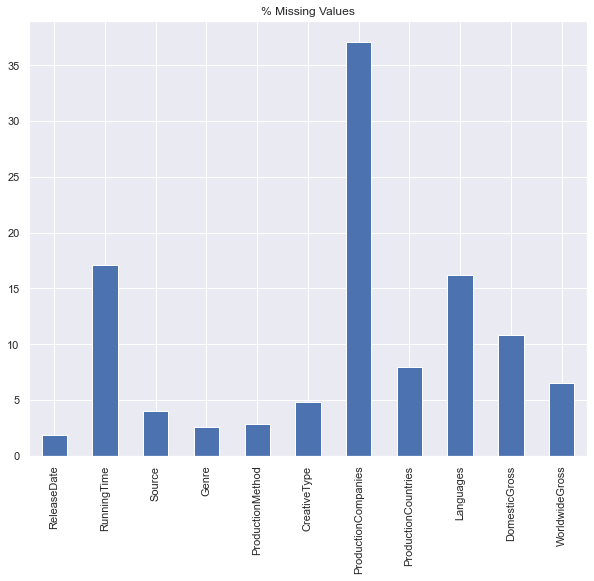

In [88]:
only_missing=Perc_Of_Missing_Values[Perc_Of_Missing_Values!=0]
plt.figure(figsize=(10, 8))
only_missing.plot(kind="bar")
plt.title("% Missing Values")
plt.show()

In [89]:
complete_df = df[~pd.isna(df).any(axis=1)].reset_index(drop=True)
complete_df.shape

(3548, 14)

#### Kiểm tra kiểu dữ liệu

Đồng bộ thông tin cột **ReleaseDate** chỉ chứa năm, ép kiểu dữ liệu thành **float**.

Thông tin cột **RunningTime** bỏ đơn vị **minutes**, lấy kiểu dữ liệu thành **float**

In [90]:
df['ReleaseDate'] = df['ReleaseDate'].transform(lambda x: str(x).split(' ')[-1])
df['ReleaseDate'] = df['ReleaseDate'].apply(pd.to_numeric, args=('coerce',))

df['RunningTime'] = df['RunningTime'].transform(lambda x: str(x).split(' ')[0])
df['RunningTime'] = df['RunningTime'].apply(pd.to_numeric, args=('coerce',))

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6286 entries, 0 to 6285
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   6286 non-null   int64  
 1   ReleaseDate          6172 non-null   float64
 2   Movie                6286 non-null   object 
 3   RunningTime          5211 non-null   float64
 4   Source               6033 non-null   object 
 5   Genre                6126 non-null   object 
 6   ProductionMethod     6110 non-null   object 
 7   CreativeType         5983 non-null   object 
 8   ProductionCompanies  3952 non-null   object 
 9   ProductionCountries  5788 non-null   object 
 10  Languages            5265 non-null   object 
 11  ProductionBudget     6286 non-null   int64  
 12  DomesticGross        5607 non-null   float64
 13  WorldwideGross       5874 non-null   float64
dtypes: float64(4), int64(2), object(8)
memory usage: 687.7+ KB


#### Thống kê tóm tắt dữ liệu số

In [92]:
df.describe()

,Id,ReleaseDate,RunningTime,ProductionBudget,DomesticGross,WorldwideGross
count,6286.000000,6172.000000,5211.000000,6.286000e+03,5.607000e+03,5.874000e+03
mean,3143.500000,2004.727317,108.412397,3.197317e+07,4.631910e+07,9.808887e+07
std,1814.756228,13.088285,20.188501,4.259353e+07,7.241485e+07,1.855515e+08
min,1.000000,1915.000000,9.000000,8.600000e+01,2.640000e+02,1.700000e+01
25%,1572.250000,2000.000000,95.000000,5.000000e+06,4.210792e+06,6.662037e+06
50%,3143.500000,2007.000000,105.000000,1.680000e+07,2.141636e+07,3.224374e+07
75%,4714.750000,2014.000000,119.000000,4.000000e+07,5.698408e+07,1.029795e+08
max,6286.000000,2025.000000,260.000000,4.000000e+08,9.366622e+08,2.845900e+09


#### Thống kê mô tả trực quan

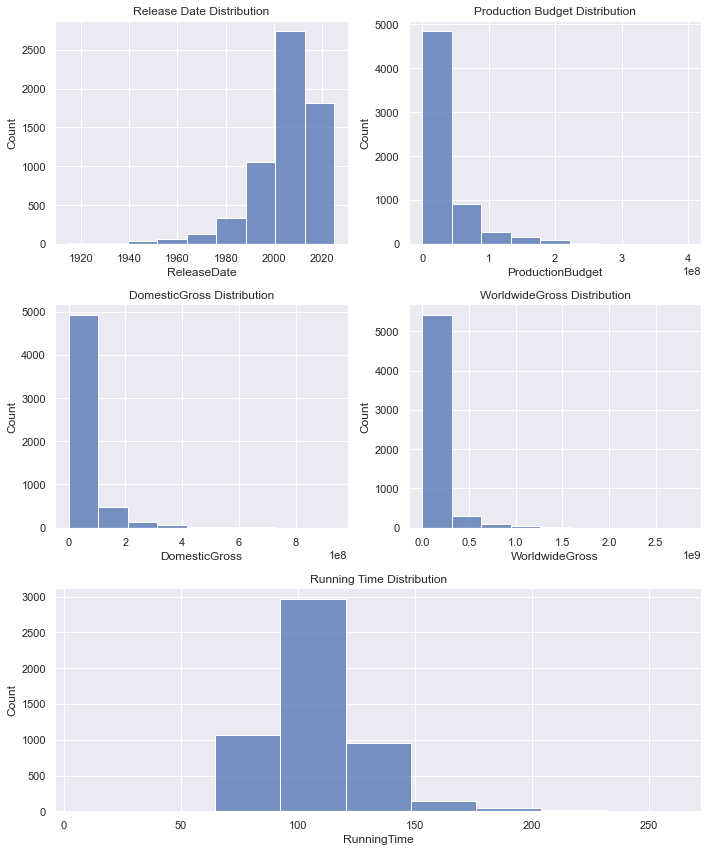

In [93]:
fig, ax = plt.subplots(3, 2, figsize=(10, 12))

ax1 = plt.subplot(321)
ax1 = sns.histplot(df['ReleaseDate'], bins=9)
ax1.set_title("Release Date Distribution")

ax3 = plt.subplot(322)
ax3 = sns.histplot(df['ProductionBudget'], bins=9)
ax3.set_title("Production Budget Distribution")

ax4 = plt.subplot(323)
ax4 = sns.histplot(df['DomesticGross'], bins=9)
ax4.set_title("DomesticGross Distribution")

ax5 = plt.subplot(324)
ax5 = sns.histplot(df['WorldwideGross'], bins=9)
ax5.set_title("WorldwideGross Distribution")

ax2 = plt.subplot(313)
ax2 = sns.histplot(df['RunningTime'], bins=9)
ax2.set_title("Running Time Distribution")

plt.tight_layout()

Từ histogram ta thấy dữ liệu ở cột **ReleaseDate** bị lệch phải, còn ở cột **ProductionBudget**, **DomesticGross**, **WorldwideGross** bị lệch trái, dữ liệu ở cột **RunningTime** phân bố chuẩn.

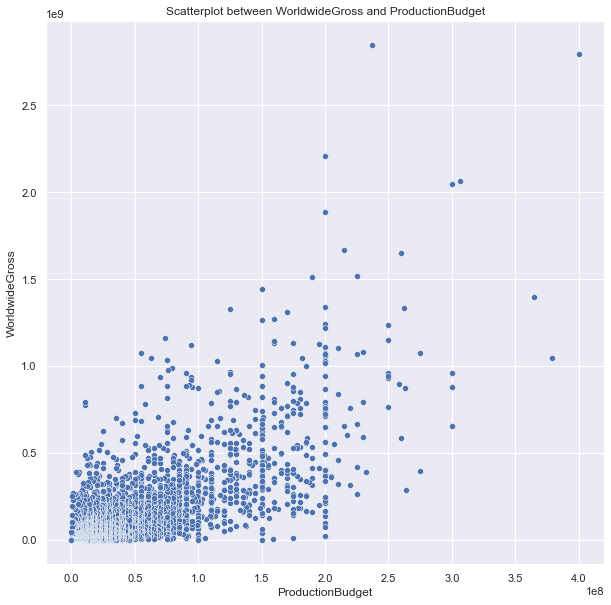

In [94]:
plt.figure(figsize=(10, 10))
sns.set(color_codes=True)
ax = sns.scatterplot(x=df['ProductionBudget'], y=df['WorldwideGross'], data=df['WorldwideGross'])
plt.title('Scatterplot between WorldwideGross and ProductionBudget')
plt.show()

Có thể thấy hai yếu tố này có một mối quan hệ tỷ lệ thuận với nhau, khi ngân sách tăng lên thì doanh thu của phim cũng có xu hướng tăng theo.

Text(0.5, 1.0, 'Correlation between numeric features')

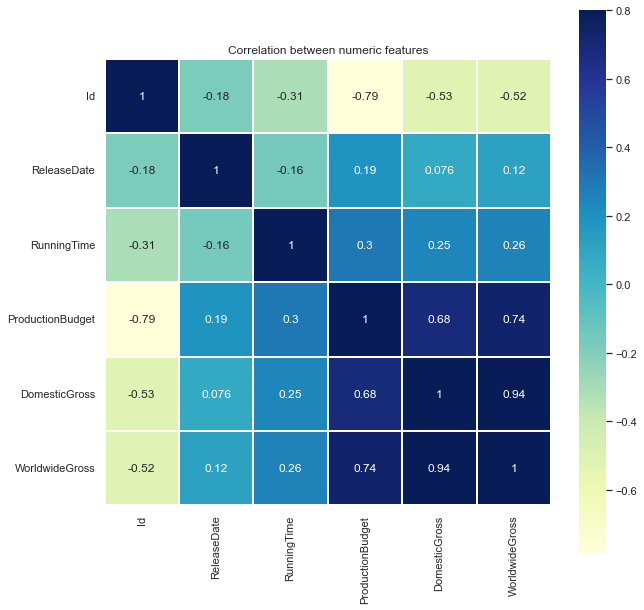

In [95]:
corr = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True, annot=True, cmap='YlGnBu', linecolor="white")
plt.title('Correlation between numeric features')

In [96]:
df.corr()["WorldwideGross"]

Id                 -0.519830
ReleaseDate         0.120878
RunningTime         0.261487
ProductionBudget    0.737119
DomesticGross       0.939153
WorldwideGross      1.000000
Name: WorldwideGross, dtype: float64

Nhìn vào heatmap ở trên, ta có thể nhận thấy **WorldwideGross** tương quan mạnh với **DomesticGross**, theo sau là **ProductionBudget**, **RunningTime**, **ReleaseDate**.

## 3. Trích xuất đặc trưng


In [97]:
colors = sns.color_palette('pastel')

### 3.1. Xử lý dữ liệu trống


#### Id

In [98]:
del df['Id']

#### DomesticGross & WorldwideGross

Xoá các dòng có phần tử dữ liệu ở cột **DomesticGross**, **WorldwideGross** bị bỏ trống, vì đây là target.

In [99]:
df = df[df['DomesticGross'].notna()]
df = df[df['WorldwideGross'].notna()]
df.shape

(5607, 13)

In [100]:
df.isnull().sum()

ReleaseDate               1
Movie                     0
RunningTime             867
Source                  189
Genre                   117
ProductionMethod        127
CreativeType            247
ProductionCompanies    1924
ProductionCountries     441
Languages               939
ProductionBudget          0
DomesticGross             0
WorldwideGross            0
dtype: int64

In [101]:
print("Percentage Of Missing Values")
Perc_Of_Missing_Values = round(df.isna().sum()/len(df)*100, 2)
Perc_Of_Missing_Values[Perc_Of_Missing_Values!=0]

Percentage Of Missing Values


ReleaseDate             0.02
RunningTime            15.46
Source                  3.37
Genre                   2.09
ProductionMethod        2.27
CreativeType            4.41
ProductionCompanies    34.31
ProductionCountries     7.87
Languages              16.75
dtype: float64

#### ReleaseDate

In [102]:
df = df[df['ReleaseDate'].notna()]
df.shape

(5606, 13)

#### RunningTime

In [103]:
class MissingDataHandler:
  @staticmethod
  def fill_nan_by_median(df: pd.DataFrame, col: str, new_col:str):
    dt = df.copy()
    median = dt[col].dropna().median()
    print(f"Median of {col} = {median}")

    dt[new_col] = dt[col]
    dt[new_col].fillna(median, inplace=True)
    return dt
  
  @staticmethod
  def fill_nan_by_mean(df: pd.DataFrame, col: str, new_col: str):
    dt = df.copy()
    mean = dt[col].dropna().mean()
    print(f"Mean of {col} = {mean}")

    dt[new_col] = dt[col]
    dt[new_col].fillna(mean, inplace=True)
    return dt

  @staticmethod
  def fill_nan_by_mode(df: pd.DataFrame, col: str, new_col: str):
    dt = df.copy()
    mode_age = dt.mode()[col].values[0]
    print(f"Mode of {col} = {mode_age}")

    dt[new_col] = dt[col]
    dt[new_col].fillna(mode_age, inplace=True)
    return dt

  @staticmethod
  def fill_nan_by_end_distribution(df: pd.DataFrame, col: str, new_col: str):
    dt = df.copy()
    extreme = dt[col].mean() + 3 * dt[col].std()
    print(f'End of distribution of {col}: {extreme}')

    dt[new_col] = dt[col].fillna(extreme)
    return dt

  @staticmethod
  def fill_nan_by_random(df: pd.DataFrame, col: str, new_col: str):
    dt = df.copy()
    number_null_row = dt[col].isnull().sum()
    random_samples = dt[col].dropna().sample(n=number_null_row, random_state=0)

    dt[new_col] = dt[col]
    random_samples.index = dt[dt[col].isnull()].index
    dt.loc[dt[col].isnull(), new_col] = random_samples
    return dt

  @staticmethod
  def fill_nan_by_arbitrary(df: pd.DataFrame, col: str, new_col: str, start: int, end: int):
    dt = df.copy()
    dt[new_col] = dt[col].fillna(np.random.randint(start, end))
    return dt

In [104]:
df['RunningTime_NAN'] = np.where(df['RunningTime'].isnull(), 1, 0)
df = MissingDataHandler.fill_nan_by_median(df, 'RunningTime', 'RunningTime_median')
df = MissingDataHandler.fill_nan_by_mean(df, 'RunningTime', 'RunningTime_mean')
df = MissingDataHandler.fill_nan_by_mode(df, 'RunningTime', 'RunningTime_mode')
df = MissingDataHandler.fill_nan_by_end_distribution(df, 'RunningTime', 'RunningTime_end_dist')
df = MissingDataHandler.fill_nan_by_random(df, 'RunningTime', 'RunningTime_random')
df = MissingDataHandler.fill_nan_by_arbitrary(df, 'RunningTime', 'RunningTime_arbitrary', start=0, end=127)

Median of RunningTime = 106.0
Mean of RunningTime = 109.39599156118143
Mode of RunningTime = 100.0
End of distribution of RunningTime: 169.34725458791968


In [105]:
print(f"Std of RunningTime = {df['RunningTime'].std()}")
print(f"Std of RunningTime_median = {df['RunningTime_median'].std()}")
print(f"Std of RunningTime_mean = {df['RunningTime_mean'].std()}")
print(f"Std of RunningTime_mode = {df['RunningTime_mode'].std()}")
print(f"Std of RunningTime_end_dist = {df['RunningTime_end_dist'].std()}")
print(f"Std of RunningTime_random = {df['RunningTime_random'].std()}")
print(f"Std of RunningTime_arbitrary = {df['RunningTime_arbitrary'].std()}")

Std of RunningTime = 19.983754342246083
Std of RunningTime_median = 18.41617346915039
Std of RunningTime_mean = 18.375223417793325
Std of RunningTime_mode = 18.68641521605531
Std of RunningTime_end_dist = 28.410909102097314
Std of RunningTime_random = 19.834493554006947
Std of RunningTime_arbitrary = 18.376520225514202


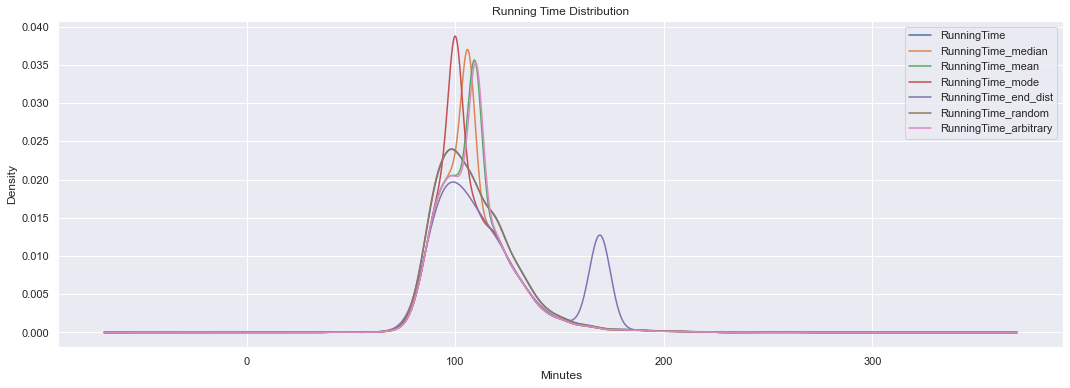

In [106]:
fig, ax = plt.subplots(figsize=(18, 6))
df.RunningTime.plot(kind='kde')
df.RunningTime_median.plot(kind='kde')
df.RunningTime_mean.plot(kind='kde')
df.RunningTime_mode.plot(kind='kde')
df.RunningTime_end_dist.plot(kind='kde')
df.RunningTime_random.plot(kind='kde')
df.RunningTime_arbitrary.plot(kind='kde')
plt.xlabel("Minutes")
plt.title("Running Time Distribution")
lines, labels = ax.get_legend_handles_labels()
plt.legend(lines, labels, loc='best')

In [107]:
del df['RunningTime_NAN']
del df['RunningTime_median']
del df['RunningTime_mean']
del df['RunningTime_mode']
del df['RunningTime_end_dist']
del df['RunningTime_random']
del df['RunningTime_arbitrary']

In [108]:
random_samples = df['RunningTime'].dropna().sample(n=df['RunningTime'].isnull().sum(),random_state=0)
df[df['RunningTime'].isnull()].index
random_samples.index = df[df['RunningTime'].isnull()].index
df['RunningTime_random']=df['RunningTime']
df.loc[df['RunningTime'].isnull(), 'RunningTime_random']=random_samples
del df['RunningTime']
df.rename(columns={'RunningTime_random': 'RunningTime'}, inplace=True)

In [109]:
df.isnull().sum()

ReleaseDate               0
Movie                     0
Source                  189
Genre                   117
ProductionMethod        127
CreativeType            246
ProductionCompanies    1923
ProductionCountries     440
Languages               938
ProductionBudget          0
DomesticGross             0
WorldwideGross            0
RunningTime               0
dtype: int64

#### Source

In [110]:
df['Source'].fillna('Others', inplace=True)
df['Source'] = df['Source'].transform(lambda x: str(x).replace('Based on ', ''))
df['Source'].value_counts()

Original Screenplay           2874
Fiction Book/Short Story      1064
Real Life Events               442
Remake                         208
Others                         189
Comic/Graphic Novel            180
TV                             165
Factual Book/Article           151
Play                            97
Game                            45
Folk Tale/Legend/Fairytale      43
Spin-Off                        29
Short Film                      25
Religious Text                  20
Musical or Opera                19
Movie                           17
Toy                             16
Theme Park Ride                  8
Compilation                      5
Musical Group                    3
Ballet                           3
Web Series                       1
Song                             1
Poem                             1
Name: Source, dtype: int64

In [111]:
df['Source'] = df['Source'].transform(lambda x: 'Others' if str(x) not in ['Original Screenplay', 'Fiction Book/Short Story', 'Real Life Events'] else x)

In [112]:
df['Source'].value_counts()

Original Screenplay         2874
Others                      1226
Fiction Book/Short Story    1064
Real Life Events             442
Name: Source, dtype: int64

#### Genre

In [113]:
df['Genre'].fillna('Others', inplace=True)
df['Genre'].value_counts()

Drama                  1515
Comedy                  939
Action                  718
Adventure               671
Thriller/Suspense       556
Horror                  444
Romantic Comedy         250
Others                  117
Documentary             110
Musical                 100
Black Comedy             99
Western                  72
Concert/Performance      14
Multiple Genres           1
Name: Genre, dtype: int64

In [114]:
df['Genre'] = df['Genre'].transform(lambda x: 'Others' if str(x) not in ['Drama', 'Comedy', 'Action', 'Adventure', 'Thriller/Suspense', 'Horror'] else x)
df['Genre'].value_counts()

Drama                1515
Comedy                939
Others                763
Action                718
Adventure             671
Thriller/Suspense     556
Horror                444
Name: Genre, dtype: int64

#### ProductionMethod

In [115]:
df['ProductionMethod'].fillna('Others', inplace=True)
df['ProductionMethod'].value_counts()

Live Action                    5036
Digital Animation               184
Animation/Live Action           173
Others                          127
Hand Animation                   69
Stop-Motion Animation            14
Rotoscoping                       2
Multiple Production Methods       1
Name: ProductionMethod, dtype: int64

In [116]:
df['ProductionMethod'] = df['ProductionMethod'].transform(lambda x: 'Others' if str(x) not in ['Live Action'] else x)
df['ProductionMethod'].value_counts()

Live Action    5036
Others          570
Name: ProductionMethod, dtype: int64

#### CreativeType

In [117]:
df['CreativeType'].fillna('Others', inplace=True)
df['CreativeType'].value_counts()

Contemporary Fiction       2810
Historical Fiction          637
Dramatization               489
Science Fiction             476
Fantasy                     382
Kids Fiction                323
Others                      246
Factual                     123
Super Hero                  114
Multiple Creative Types       6
Name: CreativeType, dtype: int64

In [118]:
df['CreativeType'] = df['CreativeType'].transform(lambda x: 'Others' if str(x) not in ['Contemporary Fiction', 'Historical Fiction', 'Dramatization', 'Science Fiction'] else x)
df['CreativeType'].value_counts()

Contemporary Fiction    2810
Others                  1194
Historical Fiction       637
Dramatization            489
Science Fiction          476
Name: CreativeType, dtype: int64

#### ProductionCompanies

In [119]:
df['ProductionCompanies'].fillna('Others', inplace=True)
df['ProductionCompanies'].value_counts()

Others                                                                            1923
Warner Bros.                                                                        28
Columbia Pictures                                                                   21
Universal Pictures                                                                  20
Walt Disney Pictures                                                                19
                                                                                  ... 
Universal Pictures, Anonymous Content, Working Title Films                           1
Summit Entertainment, Mediaset Espana, Apaches Entertainment, Telecinco Cinema       1
DreamWorks Pictures, Work After Midnight, Saturn Films                               1
Annapurna Pictures, First Light                                                      1
THINKFilm                                                                            1
Name: ProductionCompanies, Length: 3039, dt

In [120]:
data = []

df['ProductionCompanies_split'] = df['ProductionCompanies'].str.split(', ')

for i in df['ProductionCompanies_split']:
  if isinstance(i, list):
    data += i

sorted(collections.Counter(data).items(), key=lambda item: item[1], reverse = True)

[('Others', 1923),
 ('Columbia Pictures', 222),
 ('Universal Pictures', 214),
 ('Warner Bros.', 188),
 ('Paramount Pictures', 162),
 ('Relativity Media', 110),
 ('Lionsgate', 106),
 ('Walt Disney Pictures', 102),
 ('New Line Cinema', 99),
 ('Regency Enterprises', 96),
 ('20th Century Fox', 95),
 ('DreamWorks Pictures', 76),
 ('Metro-Goldwyn-Mayer Pictures', 75),
 ('Village Roadshow Productions', 74),
 ('Dune Entertainment', 68),
 ('Working Title Films', 67),
 ('Summit Entertainment', 63),
 ('Blumhouse', 60),
 ('Marvel Studios', 56),
 ('Screen Gems', 55),
 ('Canal Plus', 54),
 ('Fox Searchlight Pictures', 54),
 ('Touchstone Pictures', 51),
 ('Legendary Pictures', 47),
 ('Focus Features', 46),
 ('Amblin Entertainment', 45),
 ('Participant Media', 44),
 ('Fox 2000 Pictures', 43),
 ('RatPac Entertainment', 42),
 ('New Regency', 42),
 ('DreamWorks Animation', 40),
 ('BBC Films', 40),
 ('UK Film Council', 40),
 ('TSG Entertainment', 38),
 ('StudioCanal', 38),
 ('Tri-Star Pictures', 37),
 ('D

In [121]:
del df['ProductionCompanies_split']
del df['ProductionCompanies']

#### ProductionCountries

In [122]:
df['ProductionCountries'].value_counts()

United States                                   3908
United Kingdom                                   174
United Kingdom, United States                    168
France                                            70
Canada, United States                             50
                                                ... 
Costa Rica, United States                          1
Australia, China, Germany                          1
Canada, Czech Republic, France                     1
Czech Republic, France, Germany                    1
Islamic Republic of Iran, Italy, Switzerland       1
Name: ProductionCountries, Length: 292, dtype: int64

In [123]:
data = []

df['ProductionCountries_split'] = df['ProductionCountries'].str.split(', ')

for i in df['ProductionCountries_split']:
  if isinstance(i, list):
    data += i

del df['ProductionCountries_split']
sorted(collections.Counter(data).items(), key=lambda item: item[1], reverse = True)[:5]

[('United States', 4483),
 ('United Kingdom', 508),
 ('France', 243),
 ('Germany', 151),
 ('Canada', 146)]

In [124]:
df['ProductionCountries'].fillna('Others', inplace=True)
df['ProductionCountries'] = df['ProductionCountries'].transform(lambda x: 'Others' if str(x) not in ['United States', 'United Kingdom'] else x)
df['ProductionCountries'].value_counts()

United States     3908
Others            1524
United Kingdom     174
Name: ProductionCountries, dtype: int64

#### Languages

In [125]:
df['Languages'].value_counts()

English                                                                   4060
English, Spanish                                                            61
French                                                                      46
English, French                                                             39
Spanish                                                                     21
                                                                          ... 
Mandarin, Mongolian                                                          1
Arabic, English, German                                                      1
Arabic, English, French, German, Hungarian, Japanese, Russian, Spanish       1
English, German, Mandarin, Tibetan                                           1
Tamil                                                                        1
Name: Languages, Length: 228, dtype: int64

In [126]:
data = []

df['Languages_split'] = df['Languages'].str.split(', ')

for i in df['Languages_split']:
  if isinstance(i, list):
    data += i

del df['Languages_split']
sorted(collections.Counter(data).items(), key=lambda item: item[1], reverse = True)[:5]

[('English', 4465),
 ('French', 164),
 ('Spanish', 126),
 ('German', 74),
 ('Japanese', 52)]

In [127]:
df['Languages'].fillna('Others', inplace=True)
df['Languages'] = df['Languages'].transform(lambda x: 'English' if 'English' in str(x).split(', ') else 'Others')
df['Languages'].value_counts()

English    4459
Others     1147
Name: Languages, dtype: int64

#### Sau khi xử lý dữ liệu trống

In [128]:
df.isnull().sum()

ReleaseDate            0
Movie                  0
Source                 0
Genre                  0
ProductionMethod       0
CreativeType           0
ProductionCountries    0
Languages              0
ProductionBudget       0
DomesticGross          0
WorldwideGross         0
RunningTime            0
dtype: int64

In [129]:
df.shape

(5606, 12)

### Export ra file clean-data.csv
**File clean-data.csv có kích thước 5606x12**

In [130]:
df.to_csv('clean-data.csv')

### 3.2. Mã hóa dữ liệu phân loại

In [131]:
df = df.drop(columns=['Movie', 'DomesticGross'])
df = pd.get_dummies(df)

In [132]:
df.head()

,ReleaseDate,ProductionBudget,WorldwideGross,RunningTime,Source_Fiction Book/Short Story,Source_Original Screenplay,Source_Others,Source_Real Life Events,Genre_Action,Genre_Adventure,...,CreativeType_Contemporary Fiction,CreativeType_Dramatization,CreativeType_Historical Fiction,CreativeType_Others,CreativeType_Science Fiction,ProductionCountries_Others,ProductionCountries_United Kingdom,ProductionCountries_United States,Languages_English,Languages_Others
0,2019.0,400000000,2.797801e+09,181.0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,1,0
1,2011.0,379000000,1.045714e+09,136.0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,1,0
2,2015.0,365000000,1.395317e+09,141.0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,1,0
3,2015.0,306000000,2.064616e+09,136.0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,1,1,0
4,2018.0,300000000,2.048360e+09,156.0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,1,0


In [133]:
df.shape

(5606, 27)

### 3.3. Xử lý dữ liệu ngoại lệ

#### Kiểm tra dữ liệu ngoại lệ

<AxesSubplot:xlabel='ReleaseDate'>

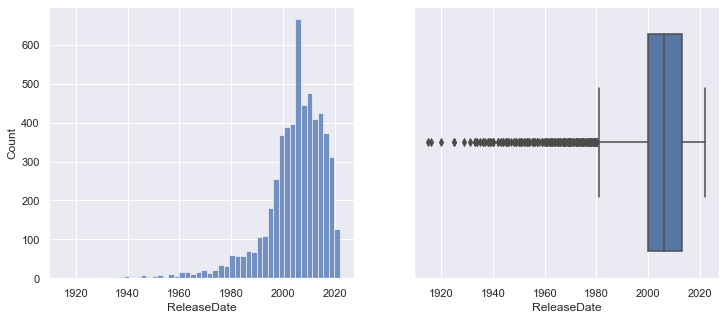

In [134]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.histplot(df['ReleaseDate'], bins=50, ax=axes[0])
sns.boxplot(data=df, x='ReleaseDate', ax=axes[1])

<AxesSubplot:xlabel='ProductionBudget'>

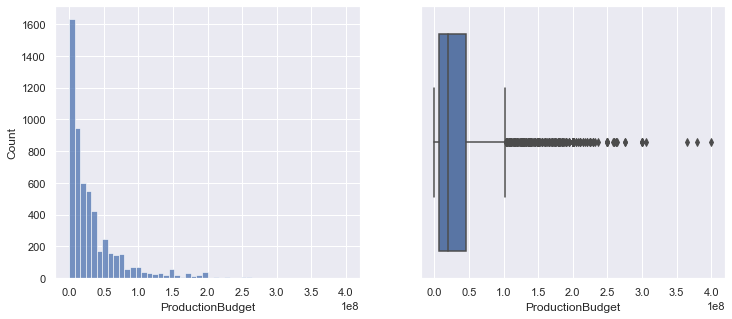

In [135]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.histplot(df['ProductionBudget'], bins=50, ax=axes[0])
sns.boxplot(data=df, x='ProductionBudget', ax=axes[1])

<AxesSubplot:xlabel='RunningTime'>

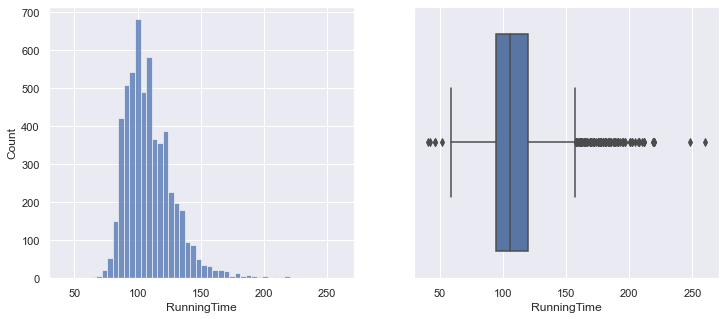

In [136]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.histplot(df['RunningTime'], bins=50, ax=axes[0])
sns.boxplot(data=df, x='RunningTime', ax=axes[1])

<AxesSubplot:xlabel='WorldwideGross'>

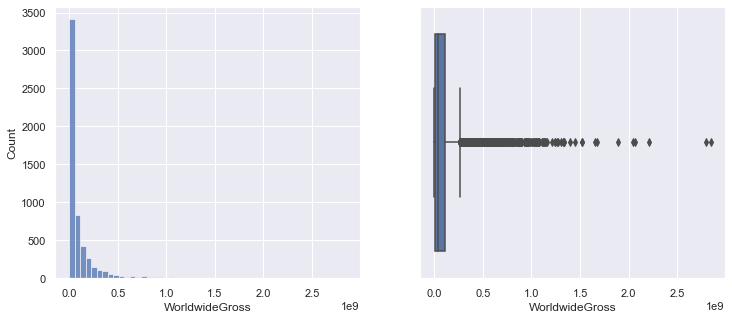

In [137]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.histplot(df['WorldwideGross'], bins=50, ax=axes[0])
sns.boxplot(data=df, x='WorldwideGross', ax=axes[1])

#### Cài đặt hàm xử lý dữ liệu ngoại lệ

In [138]:
# xử lý ngoại lệ cho phân bố lệch
def outliers_for_skewed_distribution(df, col):
    res = df.copy()
    q3 , q1 = np.percentile(res[col], [75,25])
    IQR = q3 - q1
    upper_boundary = q3 + 1.5 * IQR
    lower_boundary = q1 - 1.5 * IQR
    res[col][res[col] >= upper_boundary] = upper_boundary
    res[col][res[col] <= lower_boundary] = lower_boundary
    return res

In [139]:
# xử lý ngoại lệ cho phân bố chuẩn
def outliers_for_normal_distribution(df, col):
  res = df.copy()
  q3 , q1 = np.percentile(res[col], [75,25])
  IQR = q3 - q1
  mean = res[col].mean()
  upper_boundary = mean + 1.5 * IQR
  lower_boundary = mean - 1.5 * IQR
  res[col][res[col] >= upper_boundary] = upper_boundary
  res[col][res[col] <= lower_boundary] = lower_boundary
  return res

In [140]:
def handle_outlier(df):
  res = df.copy()
  res = outliers_for_skewed_distribution(res, 'ProductionBudget')
  res = outliers_for_normal_distribution(res, 'RunningTime')
  res = outliers_for_skewed_distribution(res, 'ReleaseDate')
  res = outliers_for_skewed_distribution(res, 'WorldwideGross')
  return res

In [141]:
df = handle_outlier(df)

C:\Users\z\AppData\Local\Temp/ipykernel_2076/1594862520.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res[col][res[col] >= upper_boundary] = upper_boundary
C:\Users\z\AppData\Local\Temp/ipykernel_2076/1594862520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res[col][res[col] <= lower_boundary] = lower_boundary
C:\Users\z\AppData\Local\Temp/ipykernel_2076/3133033384.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res[co

#### Sau khi xử lý dữ liệu ngoại lệ

<AxesSubplot:xlabel='ReleaseDate'>

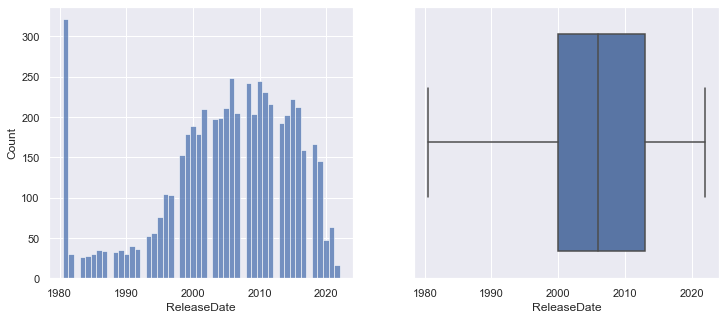

In [142]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.histplot(df['ReleaseDate'], bins=50, ax=axes[0])
sns.boxplot(data=df, x='ReleaseDate', ax=axes[1])

<AxesSubplot:xlabel='ProductionBudget'>

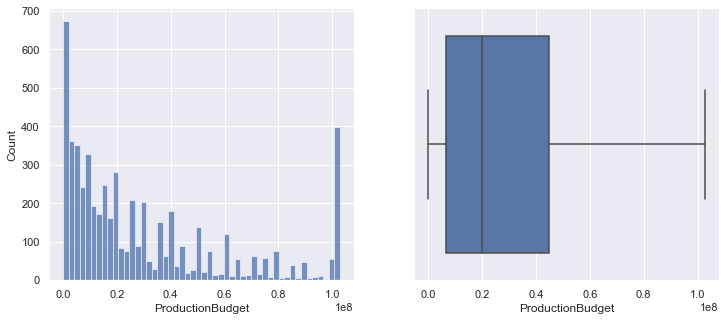

In [143]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.histplot(df['ProductionBudget'], bins=50, ax=axes[0])
sns.boxplot(data=df, x='ProductionBudget', ax=axes[1])

<AxesSubplot:xlabel='RunningTime'>

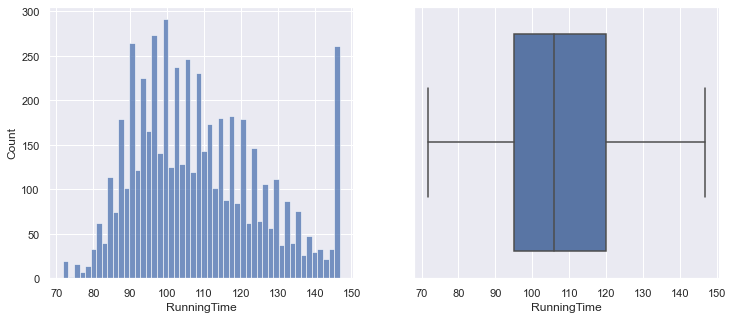

In [144]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.histplot(df['RunningTime'], bins=50, ax=axes[0])
sns.boxplot(data=df, x='RunningTime', ax=axes[1])

<AxesSubplot:xlabel='WorldwideGross'>

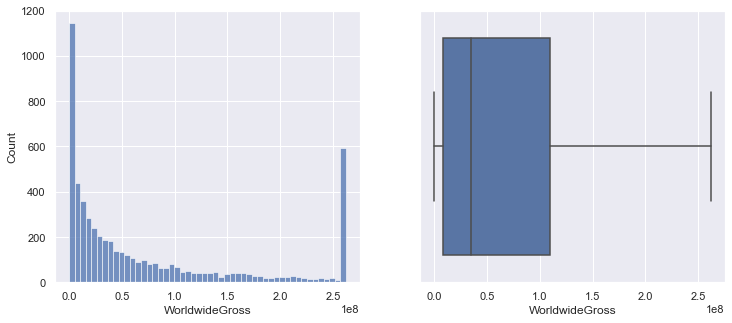

In [145]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.histplot(df['WorldwideGross'], bins=50, ax=axes[0])
sns.boxplot(data=df, x='WorldwideGross', ax=axes[1])

In [146]:
df.head()

,ReleaseDate,ProductionBudget,WorldwideGross,RunningTime,Source_Fiction Book/Short Story,Source_Original Screenplay,Source_Others,Source_Real Life Events,Genre_Action,Genre_Adventure,...,CreativeType_Contemporary Fiction,CreativeType_Dramatization,CreativeType_Historical Fiction,CreativeType_Others,CreativeType_Science Fiction,ProductionCountries_Others,ProductionCountries_United Kingdom,ProductionCountries_United States,Languages_English,Languages_Others
0,2019.0,102750000,2.622356e+08,146.779522,0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,1,0
1,2011.0,102750000,2.622356e+08,136.000000,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,1,0
2,2015.0,102750000,2.622356e+08,141.000000,0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,1,0
3,2015.0,102750000,2.622356e+08,136.000000,0,1,0,0,0,1,...,0,0,0,0,1,0,0,1,1,0
4,2018.0,102750000,2.622356e+08,146.779522,0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,1,0


array([[<AxesSubplot:title={'center':'ReleaseDate'}>,
        <AxesSubplot:title={'center':'ProductionBudget'}>],
       [<AxesSubplot:title={'center':'RunningTime'}>,
        <AxesSubplot:title={'center':'WorldwideGross'}>]], dtype=object)

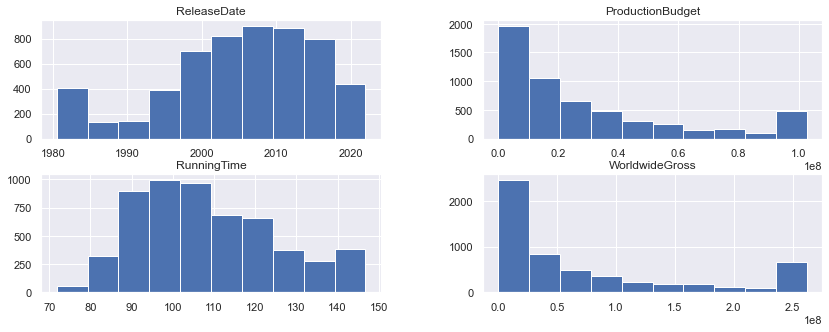

In [147]:
df[['ReleaseDate', 'ProductionBudget', 'RunningTime', 'WorldwideGross']].hist(figsize=(14, 5))

### 3.4. Chuẩn hóa dữ liệu

In [148]:
for column in ['ReleaseDate', 'ProductionBudget', 'RunningTime', 'WorldwideGross']:
  df[column] = np.log1p(df[column])

In [149]:
df.head()

,ReleaseDate,ProductionBudget,WorldwideGross,RunningTime,Source_Fiction Book/Short Story,Source_Original Screenplay,Source_Others,Source_Real Life Events,Genre_Action,Genre_Adventure,...,CreativeType_Contemporary Fiction,CreativeType_Dramatization,CreativeType_Historical Fiction,CreativeType_Others,CreativeType_Science Fiction,ProductionCountries_Others,ProductionCountries_United Kingdom,ProductionCountries_United States,Languages_English,Languages_Others
0,7.610853,18.447809,19.384754,4.995721,0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,1,0
1,7.606885,18.447809,19.384754,4.919981,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,1,0
2,7.608871,18.447809,19.384754,4.955827,0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,1,0
3,7.608871,18.447809,19.384754,4.919981,0,1,0,0,0,1,...,0,0,0,0,1,0,0,1,1,0
4,7.610358,18.447809,19.384754,4.995721,0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,1,0


array([[<AxesSubplot:title={'center':'ReleaseDate'}>,
        <AxesSubplot:title={'center':'ProductionBudget'}>],
       [<AxesSubplot:title={'center':'RunningTime'}>,
        <AxesSubplot:title={'center':'WorldwideGross'}>]], dtype=object)

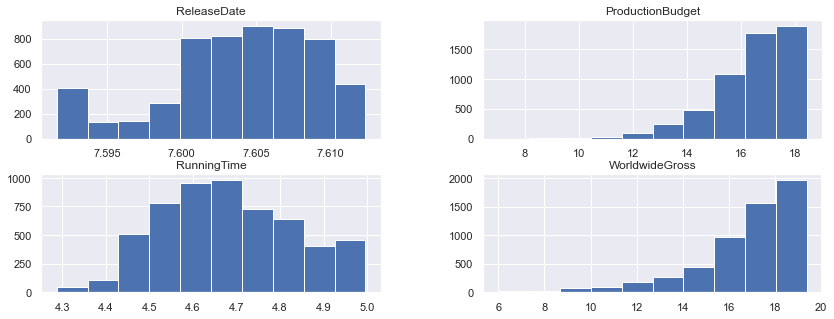

In [150]:
df[['ReleaseDate', 'ProductionBudget', 'RunningTime', 'WorldwideGross']].hist(figsize=(14, 5))

## 4. Mô hình hóa dữ liệu

### 4.1. Chia dữ liệu thành các train và test

In [151]:
df_train, df_test = train_test_split(df, test_size = 0.20, random_state=42)

In [152]:
def plot_residuals(y_test, y_pred):
  indexes = list(range(1, len(y_pred)+1))[:100]
  fig, axs = plt.subplots(1, 1, figsize=(20, 6), sharey=True)
  axs.plot(indexes, y_pred[:100], label='predicted_value', color='blue')
  axs.plot(indexes, y_test[:100], label='actual_value', color='orange')
  axs.legend()
  axs.set_ylabel('$')
  fig.suptitle('Predicted Gross VS Actual Gross')
  plt.show()

### 4.2. Linear regression

In [153]:
y_train = df_train['WorldwideGross']
X_train = df_train.copy().drop(columns=['WorldwideGross'])

In [154]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [155]:
y_test = df_test['WorldwideGross']
X_test = df_test.copy().drop(columns=['WorldwideGross'])

In [156]:
lin_predict = lin_reg.predict(X_test)

In [157]:
lin_reg.score(X_test, y_test)

0.5461189056728126

In [158]:
import math

MAE_score_LN = math.exp(MAE(y_test, lin_reg.predict(X_test))) - 1
MSE_score_LN = math.exp(math.sqrt(MSE(y_test, lin_reg.predict(X_test))))-1
R2_score_LN = R2(y_test, lin_reg.predict(X_test))
print('Model Linear Regression: ')
print('MAE :', MAE_score_LN)
print('MSE :', MSE_score_LN)
print('R2  :', R2_score_LN)

Model Linear Regression: 
MAE : 1.9723824610573097
MSE : 3.506244036500428
R2  : 0.5461189056728126


Text(0.5, 1.0, 'Linear Regression')

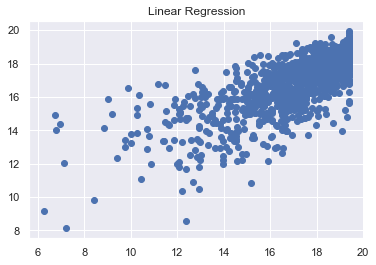

In [159]:
plt.scatter(y_test, lin_predict)
plt.title('Linear Regression')

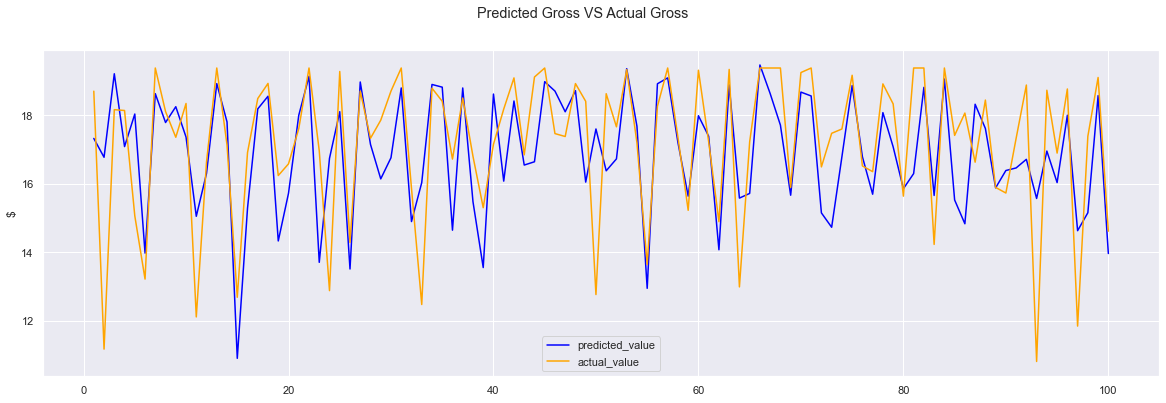

In [160]:
plot_residuals(y_test, lin_predict)

### 4.3. Support Vector Regression

In [161]:
from sklearn.model_selection import GridSearchCV

param_grid = {  'C': [0.1, 1, 10, 100],
                'degree': [3, 6, 9],
                'kernel': ['linear', 'poly', 'rbf'],
                'gamma': ['scale', 'auto']} 

grid_search = GridSearchCV(SVR(), param_grid, refit=True, verbose=3) 

grid_search.fit(X_train, y_train)

In [162]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [1, 10, 100],
              'kernel': ['rbf']}  

grid_search = GridSearchCV(SVR(), param_grid, refit=True, verbose=3) 
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...................C=1, kernel=rbf;, score=0.507 total time=   1.2s
[CV 2/5] END ...................C=1, kernel=rbf;, score=0.481 total time=   1.3s
[CV 3/5] END ...................C=1, kernel=rbf;, score=0.487 total time=   1.3s
[CV 4/5] END ...................C=1, kernel=rbf;, score=0.506 total time=   1.2s
[CV 5/5] END ...................C=1, kernel=rbf;, score=0.446 total time=   1.3s
[CV 1/5] END ..................C=10, kernel=rbf;, score=0.522 total time=   1.3s
[CV 2/5] END ..................C=10, kernel=rbf;, score=0.499 total time=   1.8s
[CV 3/5] END ..................C=10, kernel=rbf;, score=0.503 total time=   1.3s
[CV 4/5] END ..................C=10, kernel=rbf;, score=0.514 total time=   1.2s
[CV 5/5] END ..................C=10, kernel=rbf;, score=0.461 total time=   1.1s
[CV 1/5] END .................C=100, kernel=rbf;, score=0.531 total time=   1.3s
[CV 2/5] END .................C=100, kernel=rbf;,

GridSearchCV(estimator=SVR(), param_grid={'C': [1, 10, 100], 'kernel': ['rbf']},
             verbose=3)

In [163]:
grid_search.best_params_

{'C': 100, 'kernel': 'rbf'}

In [164]:
MAE_score_SVR = math.exp(MAE(y_test, grid_search.predict(X_test))) - 1
MSE_score_SVR = math.exp(math.sqrt(MSE(y_test, grid_search.predict(X_test)))) - 1
R2_score_SVR = R2(y_test, grid_search.predict(X_test))
print('Model SVR: ')
print('MAE :', MAE_score_LN)
print('MSE :', MSE_score_LN)
print('R2  :', R2_score_LN)

Model SVR: 
MAE : 1.9723824610573097
MSE : 3.506244036500428
R2  : 0.5461189056728126


In [165]:
svr_predict = grid_search.predict(X_test)

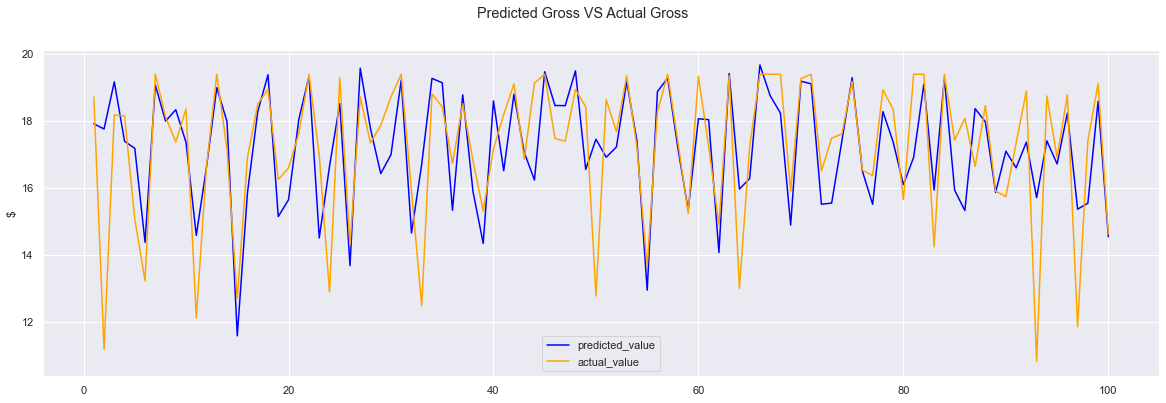

In [166]:
plot_residuals(y_test, svr_predict)

### 4.5. So sánh hiệu quả các mô hình

In [167]:
df_LN_SVR = pd.DataFrame(
    [
        [MAE_score_LN, MSE_score_LN, R2_score_LN],
        [MAE_score_SVR, MSE_score_SVR, R2_score_SVR]
    ],
    index=['Model LN', 'Model SVR'],
    columns=['MAE ($)', 'MSE ($)', 'R2'])
df_LN_SVR.style.format("{:.5f}")

,MAE ($),MSE ($),R2
Model LN,1.97238,3.50624,0.54612
Model SVR,1.85506,3.50395,0.54643


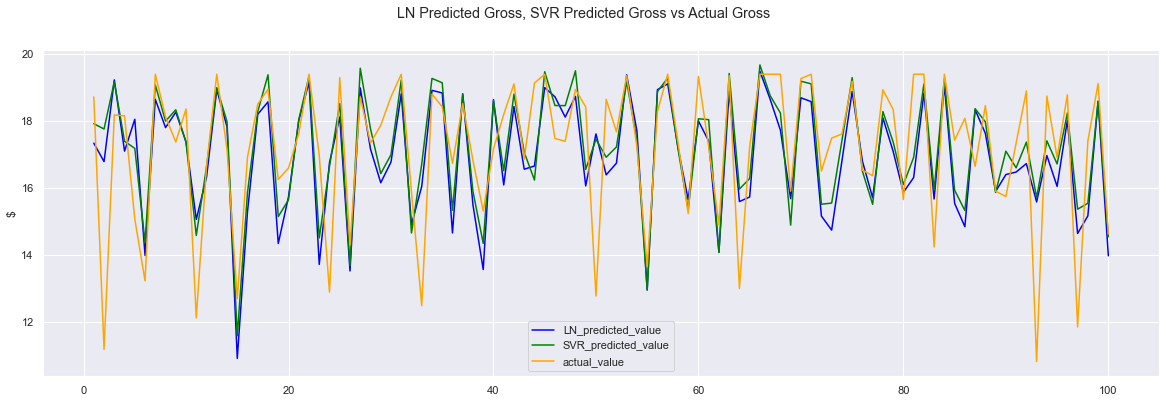

In [168]:
indexes = list(range(1, len(y_test)+1))[:100]
fig, axs = plt.subplots(1, 1, figsize=(20, 6), sharey=True)
axs.plot(indexes, lin_predict[:100], label='LN_predicted_value', color='blue')
axs.plot(indexes, svr_predict[:100], label='SVR_predicted_value', color='green')
axs.plot(indexes, y_test[:100], label='actual_value', color='orange')
axs.legend()
axs.set_ylabel('$')
fig.suptitle('LN Predicted Gross, SVR Predicted Gross vs Actual Gross')
plt.show()

## 5. Kết luận

Mô hình **Linear Regression** cho kết quả tốt hơn